In [1]:
#necessary libraries
import librosa
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#describe genres by label number
dict_characters={0: 'Hip-Hop',1: 'Pop',2: 'Folk',3: 'Rock',4: 'Experimental',5: 'International',6: 'Instrumental',7: 'Electronic'}

In [3]:
#load class_weights
class_weight=np.load('class_weight4D.npy')

In [4]:
#load the variables
x_train=np.load('x_train4D30.npy')
x_test=np.load('x_test4D30.npy')
y_trainHot=np.load('y_trainHot4D30.npy')
y_testHot=np.load('y_testHot4D30.npy')

In [5]:
# Helper Functions, Learning Curves, and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pylab as plt

#save all previous epochs for use in plotting Keras Learning Curve
#this is used in function below called plotKerasLearningCurve
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#Keras Learning Curve function
def plotKerasLearningCurve(title='Learning Curves'):
    plt.figure(figsize=(10,5))
    metrics = np.load('logs4D.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    
#Confuson Matrix function
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#deep learning libraries
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [7]:
print(x_train.shape)
print(x_test.shape)

(5597, 1, 96, 1366)
(2400, 1, 96, 1366)


In [8]:
x_train=np.moveaxis(x_train, 1, 3)
x_test=np.moveaxis(x_test, 1, 3)

In [9]:
print('train: ',x_train.shape)
print('test: ',x_test.shape)

train:  (5597, 96, 1366, 1)
test:  (2400, 96, 1366, 1)


In [10]:
#scale the features
train_mean=np.mean(x_train, axis=0)
train_std=np.std(x_train, axis=0)

In [11]:
x_train=(x_train-train_mean)/train_std
x_test=(x_test-train_mean)/train_std

In [42]:
#****EDIT THIS FOR TRYING DIFFERENT MODELS****#

#deep learning model
#a = x_train
#b = y_trainHot
#c = x_test
#d = y_testHot
#e = number of epochs
def runCNNmodel(a,b,c,d):
    batch=32
    num_labels=8
    one, two, three = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (one, two, three)
    #intialize model
    model=Sequential()
    
    #visible layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    #8 output nodes
    model.add(Flatten())
    model.add(Dense(256, activation='relu')) #hidden layers
    model.add(Dropout(0.15))
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

In [43]:
#run the model
model=runCNNmodel(x_train,y_trainHot,x_test,y_testHot)

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 94, 1364, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 47, 682, 32)       0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 47, 682, 32)       128       
_________________________________________________________________
dropout_48 (Dropout)         (None, 47, 682, 32)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 45, 680, 64)       18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 22, 340, 64)       0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 22, 340, 64)       256       
__________

Train on 5597 samples, validate on 2400 samples
Epoch 1/50
5597/5597 [==============================] - 465s 83ms/step - loss: 2.7747 - acc: 0.1819 - val_loss: 2.0894 - val_acc: 0.2408
Epoch 2/50
5597/5597 [==============================] - 469s 84ms/step - loss: 2.1296 - acc: 0.2333 - val_loss: 1.9742 - val_acc: 0.2425
Epoch 3/50
5597/5597 [==============================] - 471s 84ms/step - loss: 2.0293 - acc: 0.2503 - val_loss: 1.9202 - val_acc: 0.2842
Epoch 4/50
5597/5597 [==============================] - 456s 82ms/step - loss: 1.8731 - acc: 0.2869 - val_loss: 2.0520 - val_acc: 0.2596
Epoch 5/50
5597/5597 [==============================] - 458s 82ms/step - loss: 1.8614 - acc: 0.3036 - val_loss: 1.8267 - val_acc: 0.3083
Epoch 6/50
5597/5597 [==============================] - 493s 88ms/step - loss: 1.7447 - acc: 0.3239 - val_loss: 1.7746 - val_acc: 0.3304
Epoch 7/50
5597/5597 [==============================] - 498s 89ms/step - loss: 1.7161 - acc: 0.3388 - val_loss: 1.6657 - val_acc: 

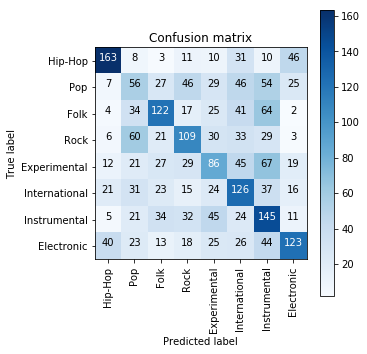

In [45]:
#compile the model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#train the model
history=model.fit(x_train,y_trainHot,batch_size=32,epochs=50,validation_data=(x_test,y_testHot),callbacks=[MetricsCheckpoint('logs4D')], class_weight=class_weight)
    
#compute predictions for confusion matrix
Y_pred = model.predict(x_test)
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(Y_pred, axis=1),target_names=list(dict_characters.values())), sep='')
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_testHot,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
#plot confusion matrix
plot_confusion_matrix(cm=confusion_mtx,classes=list(dict_characters.values()))

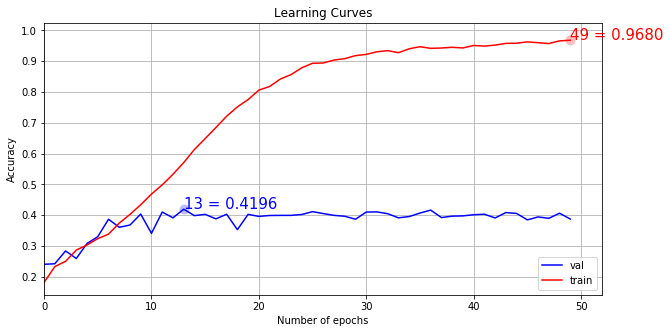

In [46]:
#plot learning curves across epochs
plotKerasLearningCurve()

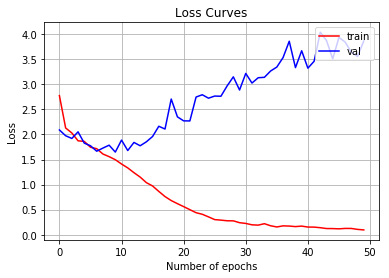

In [47]:
#plot the loss curves
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Loss Curves')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()